In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from IPython.display import display

## More Data cleaning

In [2]:
df = pd.read_csv("../data/interim/top200_pop.csv")

df.loc[:, 'artist'][1]

' ZAYN'

In [3]:
df.loc[:, 'artist'] = df.loc[:, 'artist'].str.strip()
df.columns

Index(['stream_count', 'track_id', 'title', 'artist', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'release_date', 'genre'],
      dtype='object')

In [4]:
df.drop(columns = ['track_id', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'genre'], inplace = True)

In [5]:
df.release_date = df.release_date.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d").date() if len(x) > 4 else dt.datetime.strptime(x, "%Y").date())

In [6]:
df.describe()

,stream_count,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,7.280000e+02,728.00000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000
mean,5.047859e+06,0.66539,0.645765,5.311813,-5.879253,0.598901,0.096716,0.225623,0.005651,0.165557,0.515869,117.790198,208753.648352,3.967033
std,3.343471e+06,0.12510,0.172893,3.575520,2.273340,0.490458,0.088930,0.242533,0.050669,0.127594,0.222219,29.507120,37314.045792,0.249370
min,2.541963e+06,0.25800,0.156000,0.000000,-18.064000,0.000000,0.023200,0.000569,0.000000,0.021500,0.049900,62.520000,37640.000000,1.000000
25%,3.706458e+06,0.59700,0.536500,2.000000,-7.052750,0.000000,0.043875,0.042475,0.000000,0.088575,0.344750,95.043000,187299.750000,4.000000
50%,4.366470e+06,0.67950,0.671500,6.000000,-5.537000,1.000000,0.062600,0.128500,0.000000,0.115000,0.519000,109.973000,207136.500000,4.000000
75%,4.964454e+06,0.75400,0.782000,8.000000,-4.333000,1.000000,0.111250,0.325750,0.000014,0.191750,0.687000,135.252250,227397.000000,4.000000
max,3.306719e+07,0.96700,0.972000,11.000000,-0.928000,1.000000,0.733000,0.971000,0.918000,0.914000,0.966000,212.117000,526387.000000,5.000000


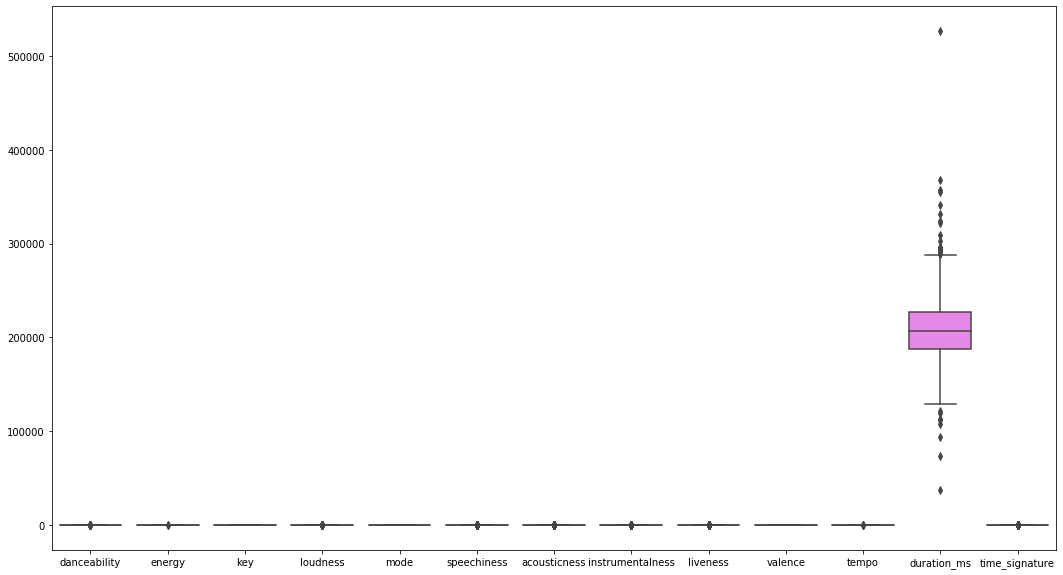

In [7]:
fig, axes = plt.subplots( figsize = (18,10))
sns.boxplot(data = df.drop(columns = ['stream_count', 'release_date']));

In [8]:
# Data clipping

def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range


outlier_treatment(df.stream_count)

(1819463.5, 6851447.5)

In [9]:
new_df = df[(df.stream_count > 1819463.5) & (df.stream_count < 6851447.5)]


In [10]:
outlier_treatment(df.duration_ms)

(127153.875, 287542.875)

In [11]:
new_df = new_df[(new_df.duration_ms > 127153.875) & (new_df.duration_ms < 287542.875)]
len(new_df)

644

## Split data into train, validation and test sets

In [13]:
# Separate features from target. Log transform y
X, y = new_df.drop(columns = ['stream_count', 'title', 'artist', 'release_date']), np.log(new_df['stream_count'])

In [14]:
# Split data into a train set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 10, shuffle = True)
#X_train, y_train = np.array(X_train), np.array(y_train)

## Data exploration

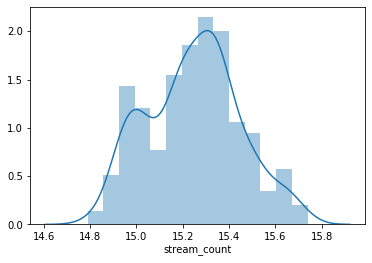

In [15]:
sns.distplot(y_train);

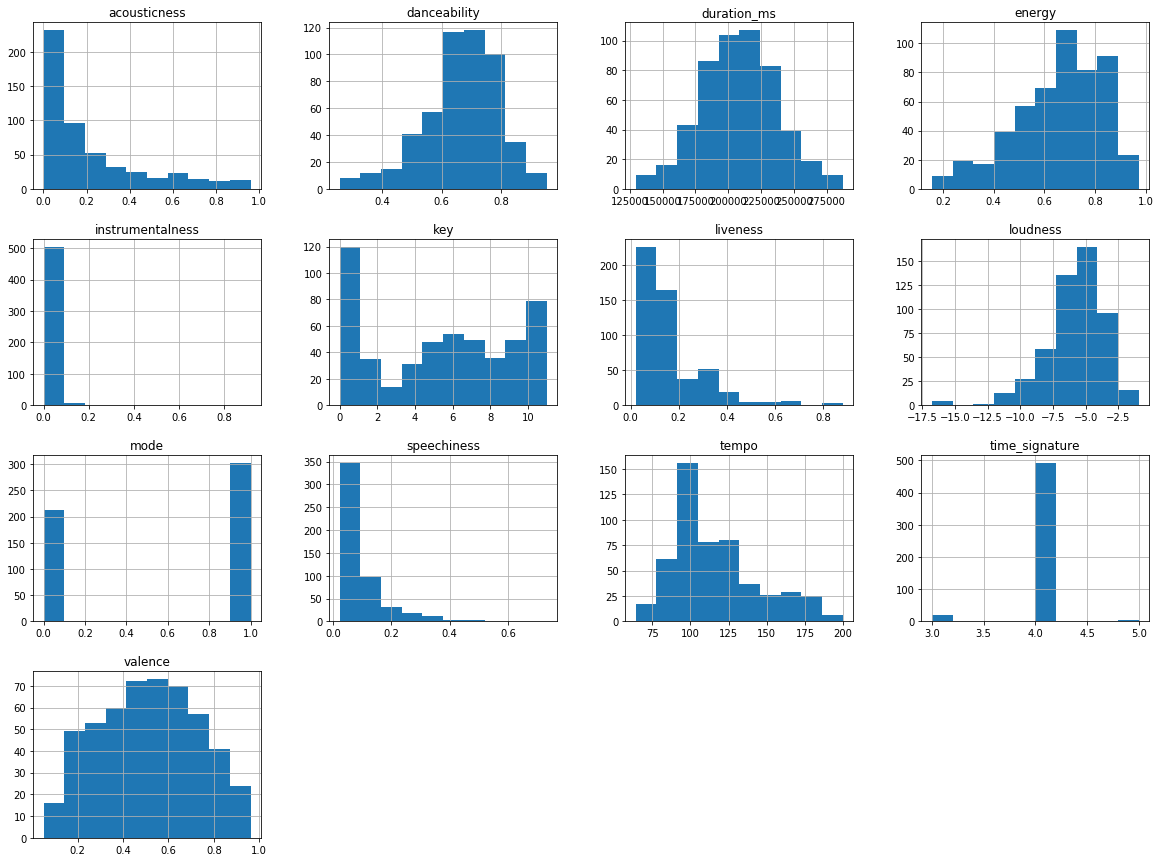

In [16]:
#fig, axes = plt.subplots(4,4, figsize = (18,10))

#counter = 0 
#for row in range(0,4):
#    for col in range(0,4):
#        if counter <= len(column_list):
#            ax = axes[row][col]
#            ax.hist(df[column_list[counter]]) 
#            ax.set_title('{}'.format(column_list[counter]))
#            counter += 1
            
#plt.tight_layout()
#plt.show();


pd.DataFrame.hist(X_train, figsize = [20,15]);

In [17]:
sorted(X_train.columns)

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'has_top_artist_prevyear',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'time_signature',
 'valence']

Loudness and energy probably shouldn't be included as features together.

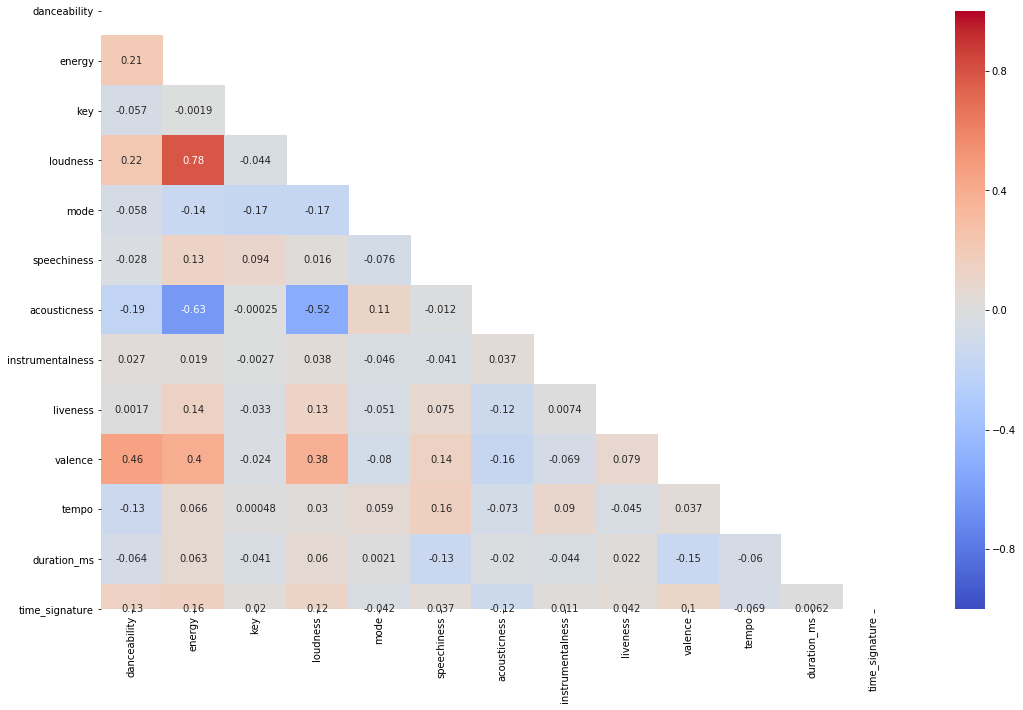

In [17]:
# Check for correlations between features

fig, ax = plt.subplots(figsize = (18,11))

mask = np.zeros_like(X_train.corr(), dtype = np.bool) # returns an array of zeros with shape of df.corr
mask[np.triu_indices_from(mask)] = True # sets left side of triangle to true
sns.heatmap(X_train.corr(), mask = mask, cmap = 'coolwarm', annot = True, vmin = -1, vmax = 1, ax =ax)

plt.show()

## Scale features 


In [21]:
#Might it be possible to use pipelines here?
kbest = SelectKBest(f_regression)
pipeline = Pipeline([
('scaler', RobustScaler()),
('kbest', kbest), 
('regr',LinearRegression())])
#grid_search = GridSearchCV(...


#scaler = RobustScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)


X_train2 = X_train.assign(log_acousticness = np.log(X_train.acousticness))
X_train2 = X_train2.assign(log_liveness = np.log(X_train.liveness))
X_train2 = X_train2.assign(log_speechiness = np.log(X_train.speechiness))
X_train2 = X_train2.assign(log_tempo = np.log(X_train.tempo))
X_train2 = X_train2.drop(columns = ['liveness', 'speechiness', 'acousticness', 'tempo'])

train = X_train2.join(y_train)
train.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'instrumentalness',
       'valence', 'duration_ms', 'time_signature', 'log_acousticness',
       'log_liveness', 'log_speechiness', 'log_tempo', 'stream_count'],
      dtype='object')

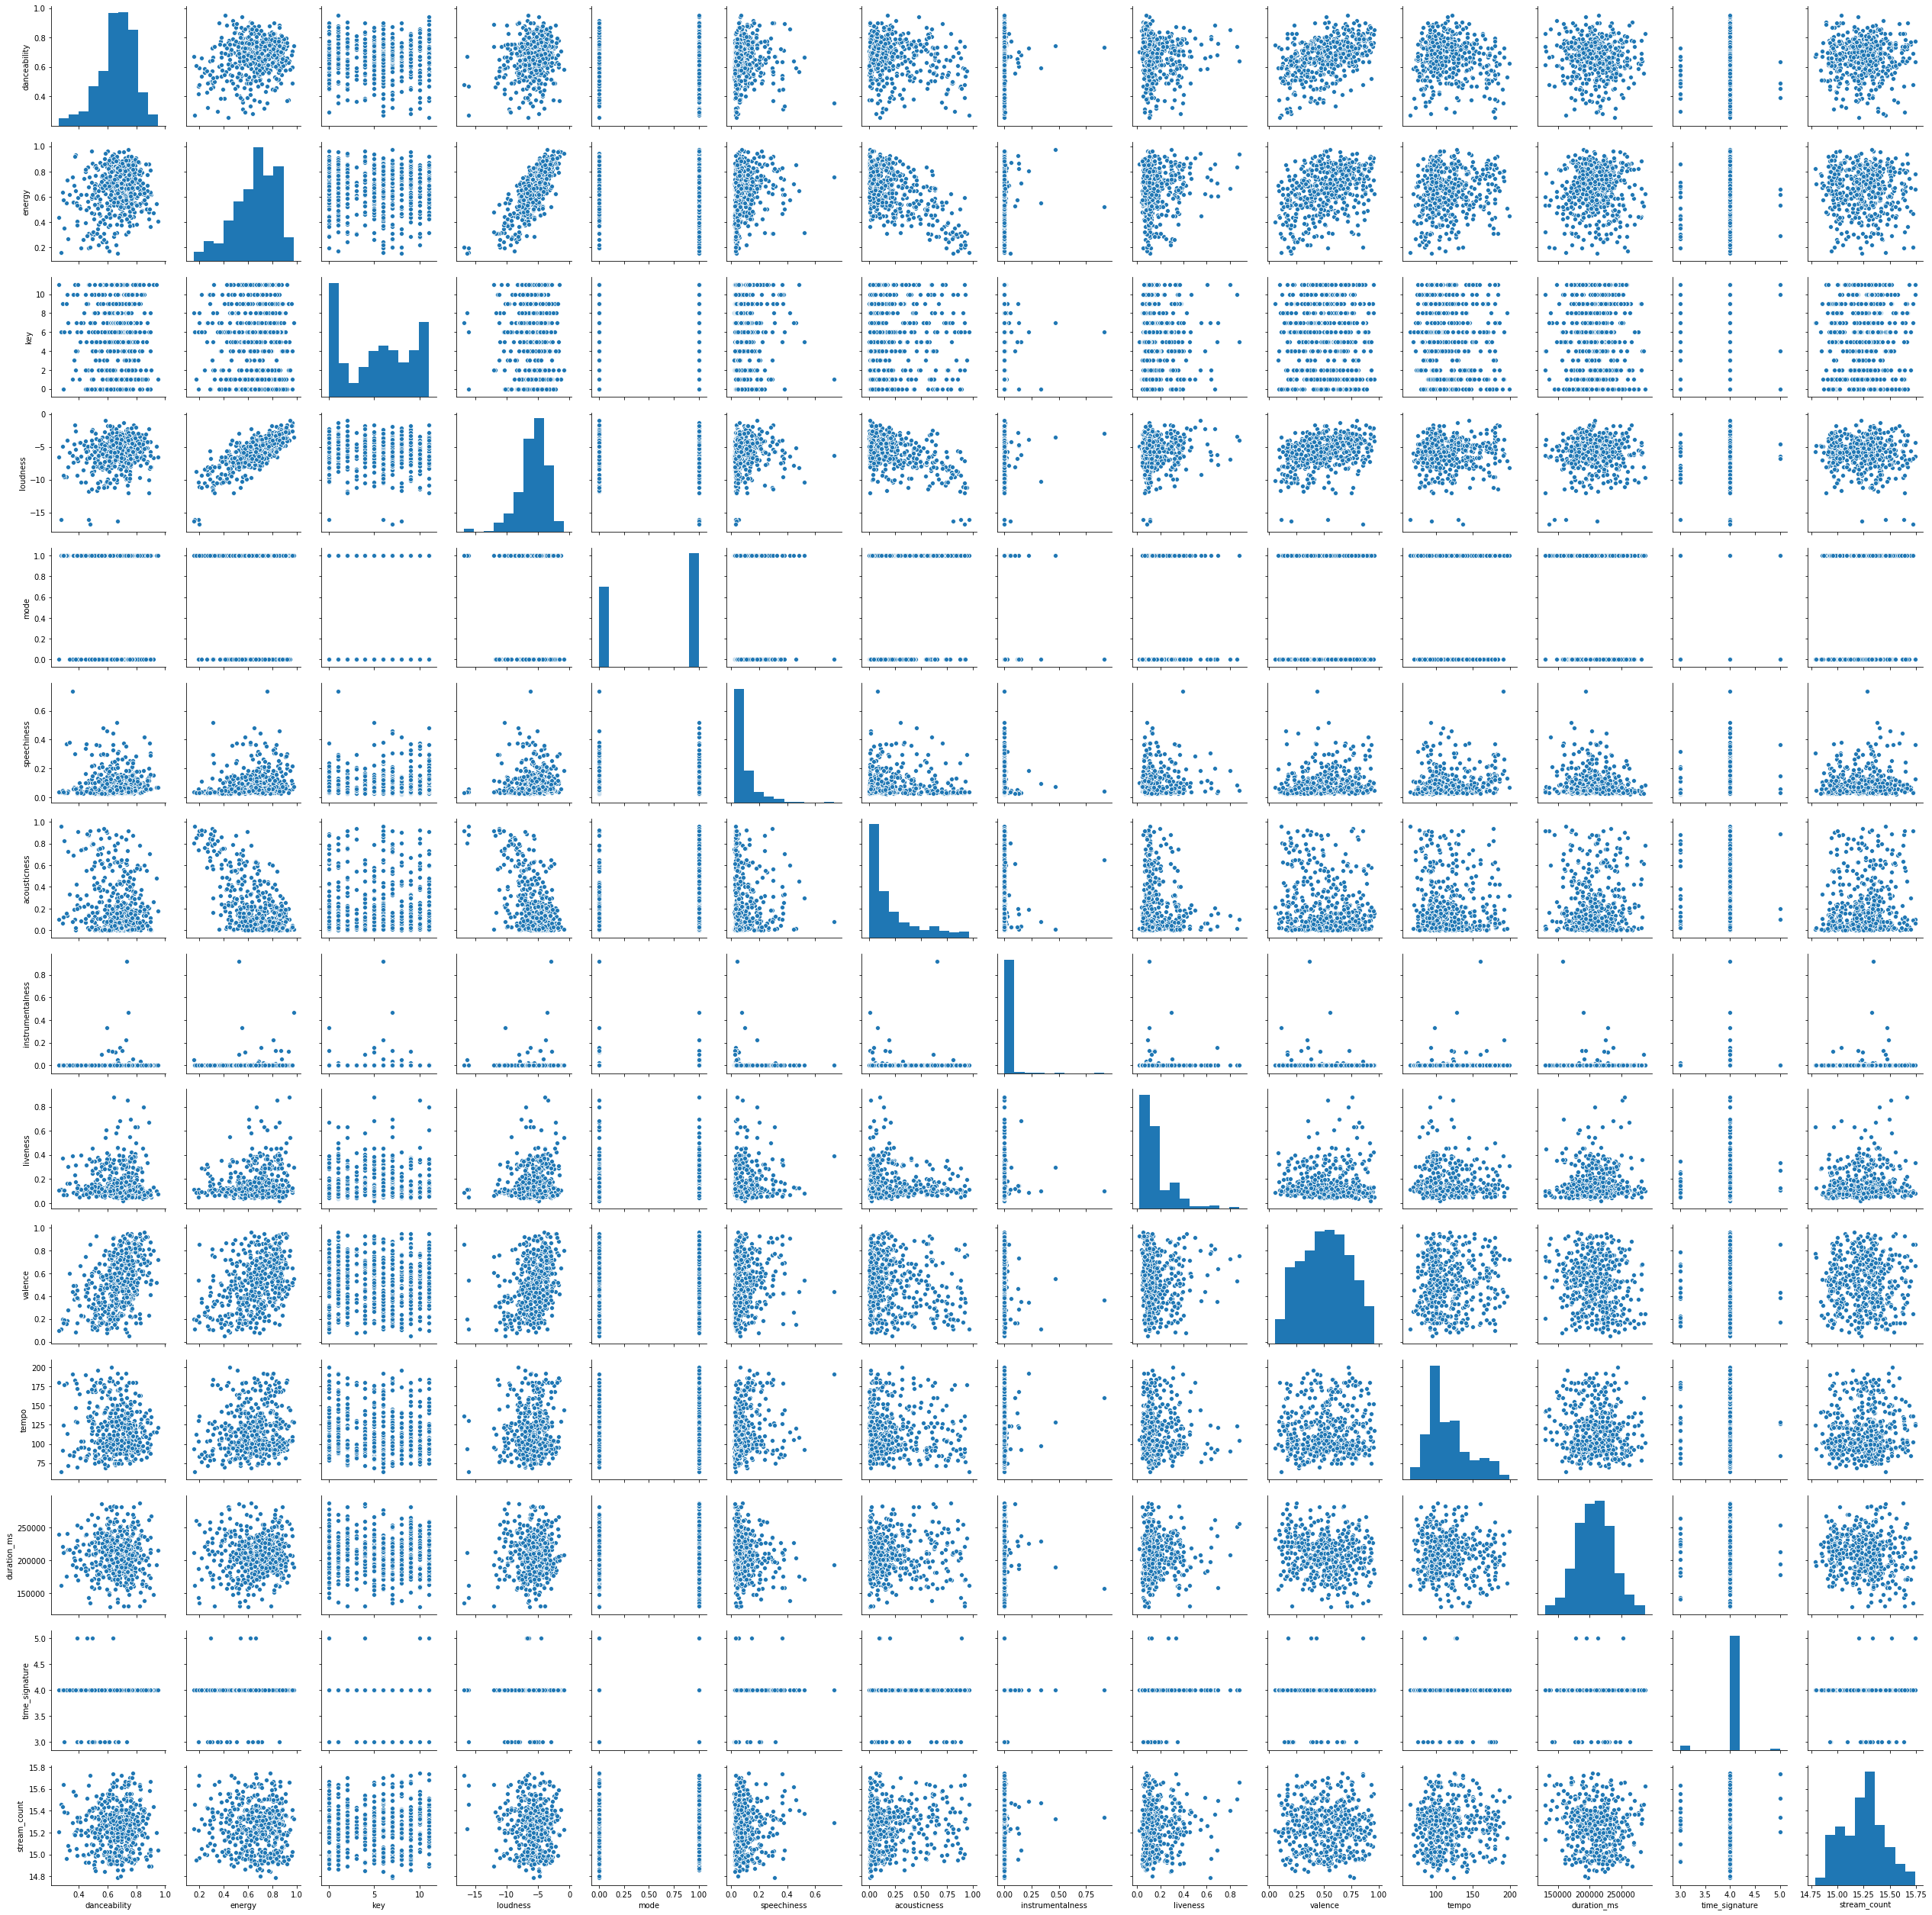

In [20]:
sns.pairplot(train);

## Features selection (within cross validation folds?)

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

# without energy

y, X = patsy.dmatrices('stream_count ~ danceability + key + loudness + mode + instrumentalness + valence + log_tempo + duration_ms + time_signature + log_acousticness + log_liveness + log_speechiness' , data = train, return_type = 'dataframe')

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.835
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           0.000886
Time:                        17:49:40   Log-Likelihood:                 116.06
No. Observations:                 515   AIC:                            -206.1
Df Residuals:                     502   BIC:                            -150.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           14.9821      0.280     53.584      0.000      14.433      15.531
danceability         0.1027      0.080      1.281      0.201      -0.055       0.260
key                  0.0033      0.002      1.341      0.181      -0.002       0.008
loudness            -0.0044      0.005     -0.968      0.334      -0.013       0.005
mode                 0.0169      0.018      0.934      0.351      -0.019       0.053
instrumentalness     0.1258      0.174      0.723      0.470      -0.216       0.468
valence              0.0095      0.049      0.194      0.846      -0.086       0.105
log_tempo            0.0873      0.038      2.273      0.023       0.012       0.163
duration_ms      -9.211e-07   3.07e-07     -3.004      0.003   -1.52e-06   -3.19e-07
time_signature      -0.0016      0.042     -0.037      0.970      -0.084       0.081
log_acousticness     0.0164      0.006      2.628      0.009       0.004       0.029
log_liveness         0.0321      0.014      2.239      0.026       0.004       0.060
log_speechiness     -0.0101      0.014     -0.743      0.458      -0.037       0.017
==============================================================================
Omnibus:                        6.859   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                4.940
Skew:                           0.107   Prob(JB):                       0.0846
Kurtosis:                       2.571   Cond. No.                     6.91e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Forward/backward filter method
#danceability + key + loudness + mode + instrumentalness + valence + tempo + log_duration_ms + time_signature + has_top_artist_prevyear + log_acousticness + log_liveness + log_speechiness' , data = train, return_type = 'dataframe')

model2 = smf.ols('stream_count ~ loudness + duration_ms', data = train)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     7.117
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           0.000894
Time:                        17:49:58   Log-Likelihood:                 106.23
No. Observations:                 515   AIC:                            -206.5
Df Residuals:                     512   BIC:                            -193.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.4203      0.068    225.361      0.000      15.286      15.555
loudness       -0.0061      0.004     -1.567      0.118      -0.014       0.002
duration_ms -1.003e-06   3.01e-07     -3.332      0.001   -1.59e-06   -4.12e-07
==============================================================================
Omnibus:                        8.890   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                5.528
Skew:                           0.063   Prob(JB):                       0.0630
Kurtosis:                       2.508   Cond. No.                     1.66e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Backwards filter method

model3 = smf.ols('stream_count ~  loudness + duration_ms + has_top_artist_prevyear' , data = train)
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stream_count   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     13.02
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           2.91e-08
Time:                        17:21:21   Log-Likelihood:                 187.80
No. Observations:                 644   AIC:                            -367.6
Df Residuals:                     640   BIC:                            -349.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  15.5147      0.038    409.559      0.000      15.440      15.589
loudness                    0.0082      0.003      2.727      0.007       0.002       0.014
duration_ms             -8.545e-07   1.47e-07     -5.806      0.000   -1.14e-06   -5.66e-07
has_top_artist_prevyear     0.0115      0.014      0.791      0.429      -0.017       0.040
==============================================================================
Omnibus:                        1.390   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.499   Jarque-Bera (JB):                1.457
Skew:                          -0.108   Prob(JB):                        0.483
Kurtosis:                       2.915   Cond. No.                     1.12e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# 'danceability', 'valence', 'loudness', 'duration_ms', 'time_signature', 'has_top_artist_prevyear','liveness'

X_train3 = X_train[['loudness', 'duration_ms', 'danceability', 'valence', 'duration_ms', 'time_signature','liveness']]
#X_train3 = X_train3.assign(log_duration_ms = np.log(X_train.duration_ms))
#X_train3 = X_train3.drop(columns = ['duration_ms'])

scaler = MinMaxScaler().fit(X_train3)

X_train3_scaled = scaler.transform(X_train3)

reg = LinearRegression().fit(X_train3_scaled, y_train)

print('R sq: ', reg.score(X_train3_scaled, y_train))
print('adj R sq: ', 1 - (1-reg.score(X_train3_scaled, y_train))*(len(y_train)-1)/(len(y_train)-X_train3_scaled.shape[1]-1))
print('coef: ', reg.coef_)


R sq:  0.036132470052088195
adj R sq:  0.022824634332886173
coef:  [-1.27976192e-01 -3.31375327e+13  3.71093750e-02  2.34375000e-02
  3.31375327e+13 -2.19726562e-02  1.12304688e-01]


In [31]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

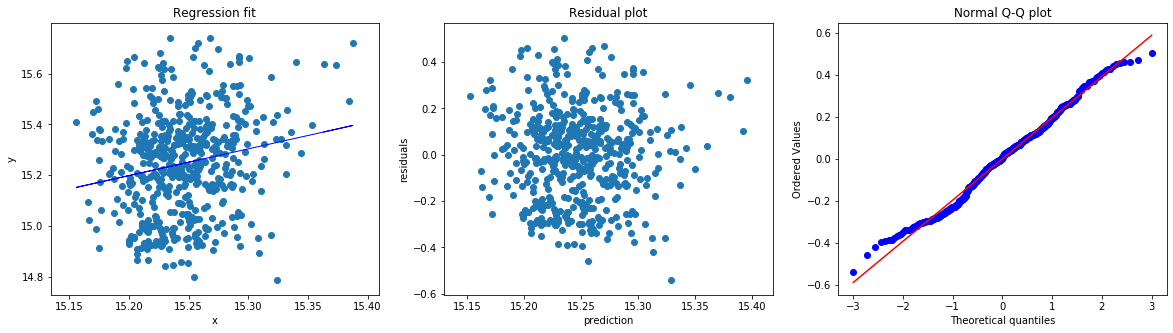

In [32]:
diagnostic_plot(reg.predict(X_train3_scaled).reshape(-1,1), y_train)

## Hyperparameters tuning and model selection